In [1]:
# !pip install matplotlib tqdm numpy

In [2]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.plotters import plot_average_execution_time
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [3]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [4]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        for subfolder in subfolders:
            print(f"Subfolder: {subfolder}")
            num_tasks = 100
            print(f"\nProcessing {num_tasks} tasks in {subfolder}")
            print(f"Evaluating algorithm: {config["alg"].name}")
            schedule_stats = review_task_sets_in_parallel_multi(algorithm=config["alg"],
                                                            folder_name=subfolder,
                                                            num_processors=config["processors"],
                                                            num_clusters=config["clusters"],
                                                            heuristic=config["heuristic"],
                                                            number_of_workers=worker_quantity)
            # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
            # execution_times[num_tasks] = success_rate
        end_time = time() - start_time

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": end_time
            }
        )

    return execution_times

In [5]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "sorting": 'du',
        "processors": 8,
        "clusters": 4,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor")


Executing with: 1 workers.
Subfolder: tasksets-multiprocessor/1

Processing 100 tasks in tasksets-multiprocessor/1
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/2

Processing 100 tasks in tasksets-multiprocessor/2
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/3

Processing 100 tasks in tasksets-multiprocessor/3
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/4

Processing 100 tasks in tasksets-multiprocessor/4
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/5

Processing 100 tasks in tasksets-multiprocessor/5
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/6

Processing 100 tasks in tasksets-multiprocessor/6
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 100
Subfolder: tasksets-multiprocessor/7

Processing 

Time taken for 1 workers: 0.34497737884521484
Time taken for 2 workers: 0.34569811820983887
Time taken for 3 workers: 0.3770456314086914
Time taken for 4 workers: 0.4307372570037842
Time taken for 5 workers: 0.4576075077056885
Time taken for 6 workers: 0.49960803985595703
Time taken for 7 workers: 0.5593001842498779
Time taken for 8 workers: 0.565565824508667
Time taken for 9 workers: 0.7111289501190186
Time taken for 10 workers: 0.7770364284515381
Time taken for 11 workers: 0.8207902908325195
Time taken for 12 workers: 0.8769352436065674
Time taken for 13 workers: 0.945873498916626
Time taken for 14 workers: 0.9722950458526611
Time taken for 15 workers: 0.9589123725891113
Time taken for 16 workers: 1.0709600448608398
Time taken for 17 workers: 1.0340800285339355
Time taken for 18 workers: 1.1095921993255615
Time taken for 19 workers: 1.2040677070617676
Time taken for 20 workers: 1.2495737075805664
Time taken for 21 workers: 1.2917466163635254
Time taken for 22 workers: 1.2836995124816

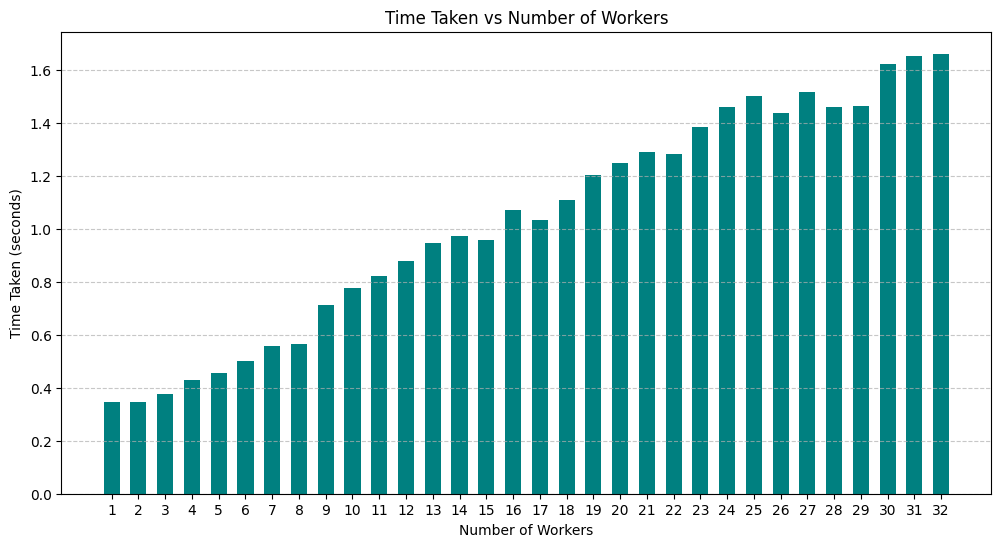

In [6]:
for result in results:
    print(f"Time taken for {result["workers"]} workers: {result["time"]}")

workers = [result["workers"] for result in results]
times = [result["time"] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(workers, times, color='teal', width=0.6)
plt.xlabel('Number of Workers')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Workers')
plt.xticks(workers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()